## BIG P3B Dataset
#### COGS 189: Brain-Computer Interfaces
- **Andrew Gibson**
- 7/30/25
- Cognitive Science, Dept.
- University of California, San Diego

Dataset: https://physionet.org/content/bigp3bci/1.0.0/

In [1]:
import numpy as np
import mne
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import random
random.seed(189)

In [2]:
def load_and_process(fname):
    assert('.edf' in fname[-4:])
   
    misc_ixs = np.arange(32, 113)
    _raw = mne.io.read_raw_edf(fname, misc=misc_ixs, stim_channel=113, preload=True)

    with _raw.info._unlock():
        _raw.info['highpass'] = 0.5
        _raw.info['lowpass'] = 30
   
    rename_channel_dict = {}
    for ix, ch in enumerate(_raw.ch_names):
        # stop after our EEG channels are renamed
        if ix >= 32:
            break
       
        rename_channel_dict[ch] = ch.split('_')[1] # get rid of 'EEG_'
   
    # manually rename FP1 and FP2 to Fp1 and Fp2
    rename_channel_dict['EEG_FP1'] = 'Fp1'
    rename_channel_dict['EEG_FP2'] = 'Fp2'
   
    _raw.rename_channels(rename_channel_dict)
   
    # load and apply our montage now that we have correct EEG names
    montage = mne.channels.make_standard_montage('standard_1005')
    _raw.set_montage(montage)

    # isolate the channels that contain relevant information.
    # note: it may be helpful to isolate the eeg data from raw using raw.get_data() beforehand
    #       alternatively, you could utilize the .pick() method of the raw object
    # https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.pick
    stim_begin = _raw.copy().pick('StimulusBegin').get_data().flatten()
    stim_type = _raw.copy().pick('StimulusType').get_data().flatten()
    stim_phase = _raw.copy().pick('PhaseInSequence').get_data().flatten()
   
    assert((len(stim_begin) == len(stim_type)) and (len(stim_type) == len(stim_phase)))
   
    # determine when the onsets happened
    stim_onsets = None
    stim_onsets = np.where(np.diff(stim_begin) == 1)[0] + 1
    stim_onsets = stim_onsets[np.where(stim_phase[stim_onsets] == 2)]
   
    assert(np.all(stim_begin[stim_onsets]))

    event_types = stim_type[stim_onsets] + 1
    assert((np.max(event_types) == 2) and (np.min(event_types) == 1))

    events = np.column_stack([stim_onsets, np.zeros_like(stim_onsets), event_types]).astype(int)
    assert(events.shape == (len(stim_onsets), 3))

    _raw.add_events(events, stim_channel='DisplayResults', replace=True)
    _raw.rename_channels({'DisplayResults': 'StimEventChannel'})

    return _raw

In [3]:
def epoch(_raw, epochs_start, epochs_end, _event_id=None, _baseline=None):
    """Build epochs for target vs non‑target"""

    _events = mne.find_events(_raw, stim_channel='StimEventChannel')

    print(_events)
    _epochs = mne.Epochs(
        _raw,
        events=_events,
        event_id=_event_id,
        tmin=epochs_start,
        tmax=epochs_end,
        baseline=_baseline,
        preload=True,
    )

    # redundant sanity check
    dt = 1/_epochs.info['sfreq']
    assert(_epochs.times[0] <= epochs_start + dt)
    assert(_epochs.times[-1] >= epochs_end - dt)

    return _epochs

In [4]:
def extract_features(_epochs, chans_to_extract, erp_win, num_windowed_means):
    """
    Takes MNE epochs object and returns X and y vars for classifier.
    """
    
    srate = 256                     # 256Hz sampling rate
    dt = 1.0 / 256                  # delta time
    
    times = _epochs.times           # get time axis from epochs 

    erp_win_start, erp_win_end = erp_win  # combine the two erp window vars into one

    erp_win_start_ix = np.argmin(np.abs(times - erp_win_start))
    erp_win_end_ix   = np.argmin(np.abs(times - erp_win_end)) # find the time bins closest to the erp times

    remainder = (erp_win_end_ix - erp_win_start_ix) % num_windowed_means
    if remainder > 0:
        print(f'[extract_features()] Warning: removing {remainder} samples off end of window')
    erp_win_end_ix -= remainder

    erp_win = np.arange(erp_win_start_ix, erp_win_end_ix)
    
    erp_win = np.arange(erp_win_start_ix, erp_win_end_ix)

    ch_ixs = [i for i, ch in enumerate(_epochs.ch_names)
              if ch in chans_to_extract]

    epochs_data = _epochs.get_data()[:, ch_ixs, :][:, :, erp_win]

    epochs_wms = windowed_means(epochs_data, num_windowed_means)
    
    # sklearn wants (trials x features)
    num_trials, num_chans, num_times = epochs_wms.shape
    num_features = num_chans * num_times
    X = epochs_wms.reshape(num_trials, num_features)

    y = _epochs.events[:, -1] - 1
    assert len(y) == num_trials

    return X, y

In [5]:
def windowed_means(data, num_means):
    # input is (observations x channels x timepoints)
    num_timepoints = data.shape[-1]
    window_length = num_timepoints // num_means
    output = []
    for i in range(num_means):
        output.append(np.mean(data[:, :, i:(i+1)*window_length], axis=-1))

    # format out to be (observations x channels x timepoints)
    output = np.array(output)
    output = np.transpose(output, (1, 2, 0))

    return np.array(output)

In [6]:
fname_train = './C_04_SE001_CB_Train02.edf'
raw_train = load_and_process(fname_train)

event_id = {
    'target': 2,
    'non-target': 1,
    }

epochs_start = -0.2
epochs_end = 0.8

epochs_train = epoch(raw_train, epochs_start, epochs_end, event_id)

num_windowed_means = 5
erp_win = [0.2, 0.6]
chans_to_extract = ['Fz', 'Pz', 'Cz']
X_train, y_train = extract_features(epochs_train, chans_to_extract, erp_win, num_windowed_means)

clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
clf.fit(X_train, y_train)

Extracting EDF parameters from /Users/andrewgibson/COGS 189 BCIs/C_04_SE001_CB_Train02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 26887  =      0.000 ...   105.027 secs...
600 events found on stim channel StimEventChannel
Event IDs: [1 2]
[[ 1544     0     1]
 [ 1576     0     1]
 [ 1608     0     1]
 ...
 [25768     0     1]
 [25800     0     1]
 [25832     0     1]]
Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 600 events and 257 original time points ...
0 bad epochs dropped
[extract_features()] Warning: removing 3 samples off end of window


/var/folders/4b/4z0svlms3076wqd7hzlk4x_c0000gn/T/ipykernel_89169/1008949097.py:5: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  _raw = mne.io.read_raw_edf(fname, misc=misc_ixs, stim_channel=113, preload=True)
/var/folders/4b/4z0svlms3076wqd7hzlk4x_c0000gn/T/ipykernel_89169/1008949097.py:5: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  _raw = mne.io.read_raw_edf(fname, misc=misc_ixs, stim_channel=113, preload=True)


LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

In [7]:
fname_val = './C_04_SE001_CB_Val.edf'
raw_val = load_and_process(fname_val)

event_id = {
    'target': 2,
    'non-target': 1,
    }

epochs_start = -0.2
epochs_end = 0.8

epochs_val = epoch(raw_val, epochs_start, epochs_end, event_id)

num_windowed_means = 5
erp_win = [0.2, 0.6]
chans_to_extract = ['Fz', 'Pz', 'Cz']
X_val, y_val = extract_features(epochs_val, chans_to_extract, erp_win, num_windowed_means)

clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
clf.fit(X_train, y_train)

# compute AUC of ROC on all of the data as a sanity check
auc = roc_auc_score(y_val, clf.decision_function(X_val))
print(f'AUC on validation data trained on train is: {auc}')

Extracting EDF parameters from /Users/andrewgibson/COGS 189 BCIs/C_04_SE001_CB_Val.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 26887  =      0.000 ...   105.027 secs...
600 events found on stim channel StimEventChannel
Event IDs: [1 2]
[[ 1544     0     1]
 [ 1576     0     1]
 [ 1608     0     1]
 ...
 [25768     0     1]
 [25800     0     1]
 [25832     0     1]]
Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 600 events and 257 original time points ...
0 bad epochs dropped
[extract_features()] Warning: removing 3 samples off end of window
AUC on validation data trained on train is: 0.7204


/var/folders/4b/4z0svlms3076wqd7hzlk4x_c0000gn/T/ipykernel_89169/1008949097.py:5: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  _raw = mne.io.read_raw_edf(fname, misc=misc_ixs, stim_channel=113, preload=True)
/var/folders/4b/4z0svlms3076wqd7hzlk4x_c0000gn/T/ipykernel_89169/1008949097.py:5: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  _raw = mne.io.read_raw_edf(fname, misc=misc_ixs, stim_channel=113, preload=True)


In [8]:
stim_chan_ixs = np.arange(32, 104) # channels 32 and after contain 1 = command IS being stimulated, 0 = command is NOT being stimulated
cmd_names = np.array(epochs_val.ch_names)[stim_chan_ixs] # extract names for stimuli

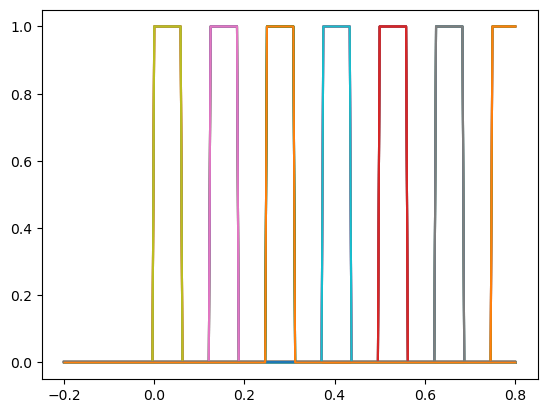

In [9]:
trial_ix = 0
times = epochs_val.times
epochs_data = epochs_val.get_data()
stimulus_data = epochs_data[:, stim_chan_ixs, :]

for chan_ix, _, in enumerate(stim_chan_ixs):
    plt.plot(times, stimulus_data[trial_ix, chan_ix, :]) # offset every iteration of this loop by 1

(0.0, 0.05)

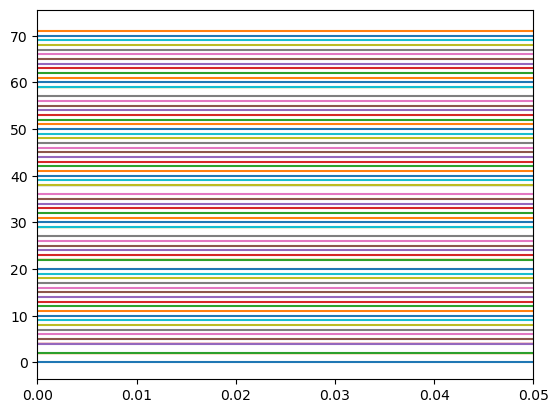

In [10]:
trial_ix = 0
times = epochs_val.times
epochs_data = epochs_val.get_data()
stimulus_data = epochs_data[:, stim_chan_ixs, :]

for chan_ix, _, in enumerate(stim_chan_ixs):
    plt.plot(times, chan_ix+stimulus_data[trial_ix, chan_ix, :]) # offset every iteration of this loop by 1

# which letters were actually flashed on every trial
plt.xlim([0, .05]) # 0-50ms isolates a single trial
# two lines 

# there are 6 stimuli that are flashed on every trial
# all of the colored bands are not nontargets
# the 6 gaps in the plot below are the targets
# if its a 1 we dont know if its a target or nontarget we want to classify if it is, but we know which commands we flashed
# the goal is to classify in real time without knowing if we have a target or nontarget

In [11]:
def get_flashed_cmds(_epochs, window_sec, stim_chan_ixs=np.arange(32, 104)):

    assert(type(_epochs) == mne.epochs.Epochs)
    assert(len(window_sec) == 2)
    assert(window_sec[1] > window_sec[0])

    times = _epochs.times
    # create window start and end from single window that we passed
    win_start = window_sec[0] # 0 index = starting time
    win_end = window_sec[1] # 1 index = end time
    # convert into indexable space
    window_ixs = np.where((times >= win_start) & (times <= win_end))[0] # convert this into the actual indices where times >= win start and <= end
    cmd_names = np.array(_epochs.ch_names)[stim_chan_ixs] # extract channel names of commands

    # epochs data's format: (num_trials, num_channels, num_timepoints)
    stim_data = _epochs.get_data()[:, stim_chan_ixs, :]

    cmds_flashed_per_trial = []
    for trial_ix in range(stim_data.shape[0]):
        mean_amplitude = np.mean(stim_data[trial_ix, :, window_ixs], axis=0) # compute mean amplitude within window of interest
        flashed_ixs = np.where(mean_amplitude > 0)[0] # b/c of the offset it won't be 1 exactly anymore, so we deal with that
        # so we can just see when stim chans have a value > 0
        cmds_flashed = cmd_names[flashed_ixs]
        cmds_flashed_per_trial.append(cmds_flashed) 
        # return a numpy array (600 trials x 6 commands per trials)
        
    return np.array(cmds_flashed_per_trial)

In [12]:
# useful to define how many trials we have per block (command)
num_trials = len(y_val) # could use on anything with len of num trials = 600
word_length = 5 # num letter in word
num_trials_per_cmd = num_trials // word_length # == 120
# b/c we want to see how well the speller can predict per command

# get info about which command was flashed during each trial
flash_window = [0, 0.0625] # sec; relative to onset
flashed_cmds = get_flashed_cmds(epochs_val, flash_window)

assert(len(flashed_cmds) == len(y_val))

Text(0, 0.5, 'Command Index')

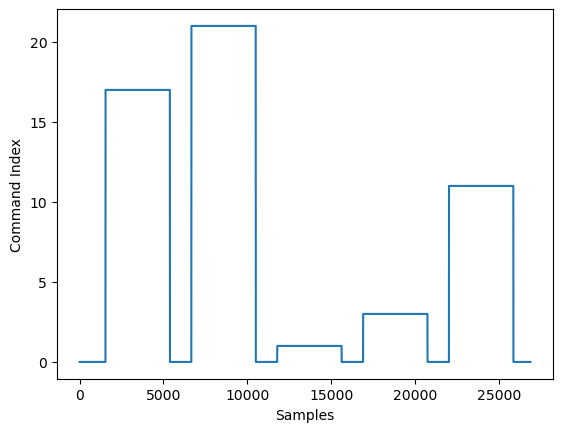

In [13]:
ch_names = epochs_val.ch_names
ch_names_dict = {ch_names[i]: i for i in range(len(ch_names))}
current_target_ix = ch_names_dict['CurrentTarget'] # current target is nonbinary digital input (this is from the original experiment/paper)
# if current target is A, value = 1; if B, then value = 2; when user takes break = 0

current_target = raw_val.get_data()[current_target_ix, :] # see how current target changes over entire time course
plt.plot(current_target)
plt.xlabel('Samples')
plt.ylabel('Command Index')

In [14]:
def extract_target_cmds(_epochs, current_target_ch_name='CurrentTarget', stim_chan_ixs=np.arange(32, 104)):
    assert(type(_epochs) is mne.epochs.Epochs)

    # how to get the location of current target w/o a dict
    current_target_ch_ix = np.where(np.array(_epochs.ch_names) == current_target_ch_name)[0][0] # ixing to find current target channel exists in epochs data
    # max value grabs the index that corresponds to which one of the commands is being stimulated
    cmd_ix_per_trial = np.max(_epochs.get_data()[:, current_target_ch_ix, :], axis=-1).astype(int) # only want current target channel ix and every trial
    cmd_ix_per_trial -= 1 # we index -1 since A is index 0 in python, but would be digitized as 1 b/c in the timeseries data 0 means a break
    assert(len(cmd_ix_per_trial) == len(_epochs.events)) # both should be 600

    # now let's return the actual cmd name
    cmd_names = np.array(_epochs.ch_names)[stim_chan_ixs] # create cmd names from stim channel indices
    target_cmd_per_trial = [cmd_names[i] for i in cmd_ix_per_trial] # list comprehension to extract the target command from every single trial
    # this should also be of len 600
    
    return target_cmd_per_trial

In [15]:
def extract_target_cmds(_epochs, current_target_ch_name='CurrentTarget', stim_chan_ixs=np.arange(32, 104)):
    current_target_ch_ix = np.where(np.array(_epochs.ch_names) == current_target_ch_name)[0][0]
    cmd_ix_per_trial = np.max(_epochs.get_data()[:, current_target_ch_ix, :], axis=-1).astype(int)
    cmd_ix_per_trial -= 1
    assert(len(cmd_ix_per_trial) == len(_epochs.events))

    cmd_names = np.array(_epochs.ch_names)[stim_chan_ixs]
    target_cmd_per_trial = [cmd_names[i] for i in cmd_ix_per_trial]
    return target_cmd_per_trial

target_cmds = extract_target_cmds(epochs_val)

In [16]:
# info about target cmd per block
target_cmds = extract_target_cmds(epochs_val) # per trial

In [17]:
# now that we have the data organized per trial and we know how to divide those trials into the indiv. cmd blocks
# ...we can create these multi-dimensional structures that will allow us to make decisions at the indiv. character level
X_val_per_block = [] # numpy arrays added to this so thats equal to the total num of blocks we have
y_val_per_block = [] # both these will have 5 different indexable elements in them
flashed_cmds_per_block = [] # same for these next two as well (120 elements (120 total trials per block))
target_cmds_per_block = [] # 5 different values, but just a single thing
target_word = '' # debug message: this is the word the user was trying to copy spell

In [18]:
for block_ix in range(word_length):
    target_cmd = target_cmds[block_ix*num_trials_per_cmd] # target commands will be the same for each trial within a block
    target_cmds_per_block.append(target_cmd)
    target_word += target_cmd.split('_')[0] # extract just the name of the command (because the actual cmds contain the row and col ix w/ _ )

    ixs = np.arange(block_ix*num_trials_per_cmd, # from 1st trial at start of block to last trial at end of block
                    (block_ix+1)*num_trials_per_cmd)
    X_val_per_block.append(X_val[ixs, :]) # just extract those ix subsets from X val, y val, and flashed cmds
    y_val_per_block.append(y_val[ixs])
    flashed_cmds_per_block.append(flashed_cmds[ixs])

print(f'Our target word was {target_word}')

Our target word was QUACK


In [19]:
# see how well our clf can predict within a single block:
block_ix = 0
block0_preds = clf.predict(X_val_per_block[block_ix])
np.unique(block0_preds, return_counts=True)
# discrepany aside, this is a problem in general b/c we are only going to be making decisions off 2 of our trials within 118 blocks
# need a strategy to extract information from every single one of our trials, not just the target trials

(array([0, 1]), array([118,   2]))

In [20]:
# proba function from sklearn will give us the probability of the output belonging to the target or nontarget class
# determine the most probable trial over all 120 of them per cmd
cmd_probas = [{cmd_name: 0.0 for cmd_name in cmd_names} for _ in range(word_length)]
# above: 1st comprehension is a list with 5 dicts
# within that is a dict comprehension with values all zero and the keys are all of the stimuli
# goal: update the values on each trial to predict the most confident class as a result of every single trial within the block
for block_ix in range(word_length):
    X = X_val_per_block[block_ix] # extract just the X per block (120 observations x 15 features)
    target_probas = clf.predict_proba(X)[:, 1] # just save 2nd col = confidence that every single trial within that block is a target

    # now determine which cmds were flashed per trial and boost their proba
    # iterate thru data per num trials to update probs at indiv trial lvl
    for trial_ix in range(num_trials_per_cmd):
        flashed_cluster = flashed_cmds_per_block[block_ix][trial_ix] # extract which cmds actually flashed at every trial
        for cmd in flashed_cluster:
            cmd_probas[block_ix][cmd] += target_probas[trial_ix] # add target probability to that command

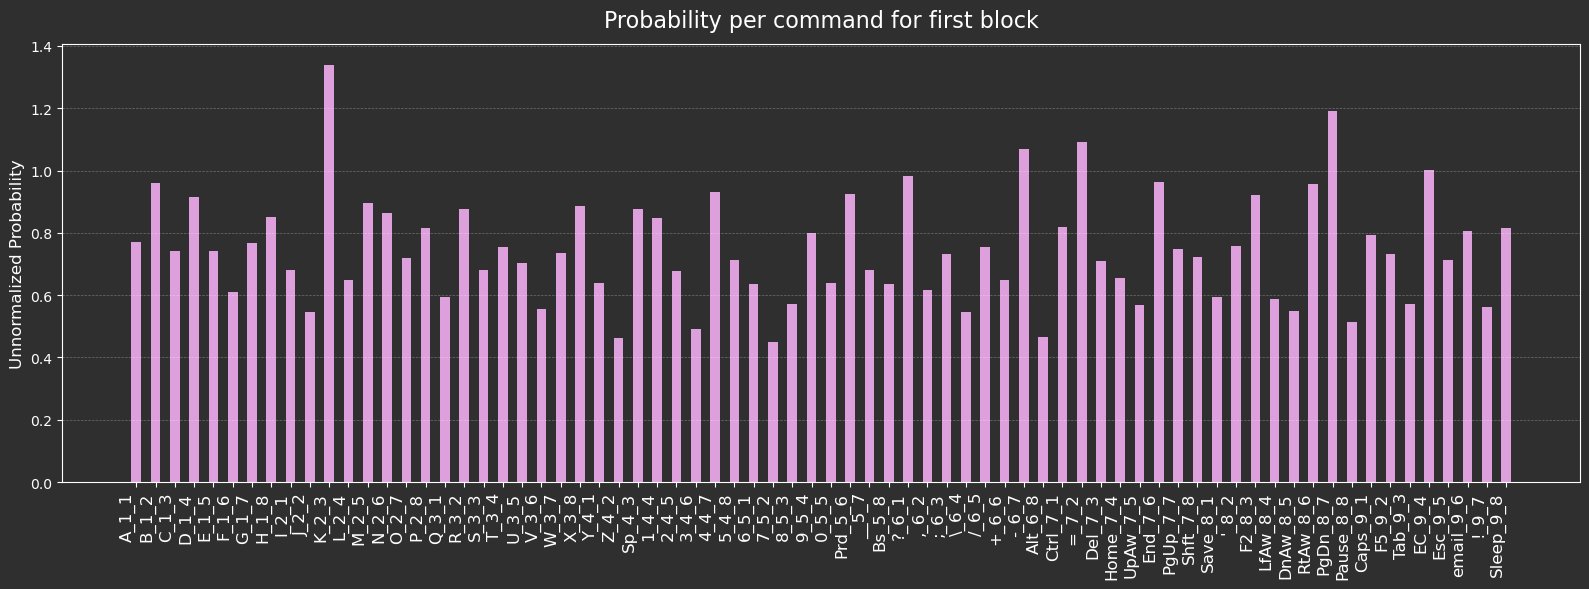

In [22]:
### plotting the distribution of the commands
x_labels = list(cmd_probas[block_ix].keys())
y = list(cmd_probas[block_ix].values())
x_ticks_num = np.arange(0, len(y))

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(16, 6))
fig.patch.set_facecolor('#2F2F2F')
ax.set_facecolor('#2F2F2F')

bars = ax.bar(x_ticks_num, y, color='plum', edgecolor='none', width=0.5)

ax.set_xticks(x_ticks_num)
ax.set_xticklabels(x_labels, rotation=90, ha='right', fontsize=12)
ax.set_ylabel('Unnormalized Probability',      fontsize=12, color='white')
ax.set_title('Probability per command for first block', fontsize=16, color='white', pad=12)

ax.grid(axis='y', color='white', linestyle='--', alpha=0.3, linewidth=0.5)

plt.tight_layout()
plt.show()

In [23]:
# K_2_3 has the highest probability = most common command

In [24]:
### predict the highest probability cmd from each block
# "one final for loop to rule them all"
predicted_cmds = []
predicted_word = ''
for block_ix in range(word_length):
    # dict-friendly (unsorted) argmax for choosing our command
    predicted_cmd = max(cmd_probas[block_ix], key=cmd_probas[block_ix].get) # extract value with the highest unnormalized probability
    predicted_cmds.append(predicted_cmd)
    predicted_word += predicted_cmd.split('_')[0] # get rid of row and col ixs

print(f'Our predicted word being spelled was: {predicted_word}')

Our predicted word being spelled was: BBsACK
